In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import tifffile as tiff

# Load your image and ground truth mask

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tiff.imread(img_path)  
        if img is not None:
            img = img / np.max(img) #  255.0  # Normalize to [0, 1]
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
            images.append(img)
    return np.array(images)

# Load images
X_train = load_images_from_folder(r"C:\Users\3i\SBKP_TEST\TrainingImages")

def load_masks_from_folder(folder):
    masks = []
    for filename in os.listdir(folder):
        mask_path = os.path.join(folder, filename)
        mask = tiff.imread(mask_path)  # Read as grayscale
        if mask is not None:
            mask = mask / np.max(mask)  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)
    return np.array(masks)

# Load masks
Y_train = load_masks_from_folder(r"C:\Users\3i\SBKP_TEST\TrainingMasks")



In [7]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
Y_train = (Y_train > 0).astype(np.uint8)


X_train shape: (600, 256, 256, 1)
Y_train shape: (600, 256, 256, 1)


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, ReLU

def create_2d_unet(input_shape, num_classes):
    # Contracting path
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    b1 = tf.keras.layers.BatchNormalization()(conv1)
    r1 = tf.keras.layers.ReLU()(b1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(r1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    b2 = tf.keras.layers.BatchNormalization()(conv2)
    r2 = tf.keras.layers.ReLU()(b2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(r2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    b3 = tf.keras.layers.BatchNormalization()(conv3)
    r3 = tf.keras.layers.ReLU()(b3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(r3)

    # Bottom
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    b4 = tf.keras.layers.BatchNormalization()(conv4)
    r4 = tf.keras.layers.ReLU()(b4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(r4)

    # Expanding path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    up5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=-1)
    merge5 = tf.keras.layers.BatchNormalization()(merge5)
    merge5 = tf.keras.layers.ReLU()(merge5)

    up6 = UpSampling2D(size=(2, 2))(merge5)
    up6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    up6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=-1)
    merge6 = tf.keras.layers.BatchNormalization()(merge6)
    merge6 = tf.keras.layers.ReLU()(merge6)

    up7 = UpSampling2D(size=(2, 2))(merge6)
    up7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    up7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=-1)
    merge7 = tf.keras.layers.BatchNormalization()(merge7)
    merge7 = tf.keras.layers.ReLU()(merge7)

    # Output
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(merge7)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5  # Smoothing factor to prevent division by zero
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient
    return dice_loss

#I did not write this, I do not remember where this is from, might be a gpt unclear
def tversky_loss(y_true, y_pred, alpha=0.2, beta=0.8, smooth=1e-5):
    """
    Tversky loss function for binary segmentation.
    y_true: Ground truth binary masks.
    y_pred: Predicted binary masks.
    alpha: Weight of the false positives penalty.
    beta: Weight of the false negatives penalty.
    smooth: Smoothing factor to prevent division by zero.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Flatten the inputs
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Calculate the true positives, false positives, and false negatives
    true_positives = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_positives = tf.reduce_sum((1 - y_true_flat) * y_pred_flat)
    false_negatives = tf.reduce_sum(y_true_flat * (1 - y_pred_flat))

    # Calculate the Tversky coefficient
    tversky_coefficient = (true_positives + smooth) / (true_positives + alpha * false_positives + beta * false_negatives + smooth)

    # Calculate the Tversky loss
    tversky_loss = 1.0 - tversky_coefficient

    return tversky_loss

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=tversky_loss, metrics=[dice_loss, "accuracy"])

In [14]:
# Assuming you have prepared your training data
# X_train = np.array([image])  # Replace with your actual training images
# Y_train = np.array([mask])   # Replace with your actual masks

model = create_2d_unet((256, 256, 1),1)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=tversky_loss, metrics=[dice_loss, "accuracy"])
model.summary()

model.fit(X_train, Y_train, batch_size=1, epochs=10)
#we can do some more fancy stuff with training if necessary

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

In [6]:
# Save the entire model to a keras file
model.save(r"C:\Users\3i\SBKP_TEST\my_model.keras")


1/1 [==============================] - 0s 26ms/step


(256, 256)

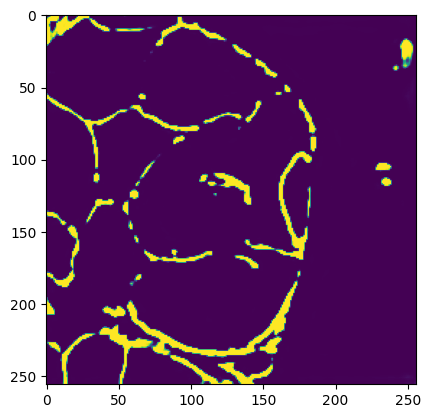

In [20]:
# Load and preprocess a new image
new_image = tiff.imread(r"C:\Users\3i\SBKP_TEST\TrainingImages\subimage_z1_y1_x1.tif")


new_image = new_image / np.max(new_image)
new_image = np.expand_dims(new_image, axis=-1)

# Predict the mask
predicted_mask = model.predict(np.expand_dims(new_image, axis=0))
predicted_mask=np.squeeze(predicted_mask)
# print(predicted_mask)
import matplotlib.pyplot as plt
plt.imshow(predicted_mask)
# Convert to the range [0, 65535]
#predicted_mask = (predicted_mask * 65535).astype(np.uint16)

np.shape(predicted_mask)

# Convert to unsigned int 16 for SB
#final_image_uint16 = predicted_mask.astype(np.uint16)

# Save the result to a 16-bit TIFF file
#file_path = 'TF_Prediction.tif'
#tiff.imwrite(file_path, final_image_uint16)

#print(f"Predicted Mask saved to {file_path}")

# Post-process and visualize the result
#predicted_mask = (predicted_mask[0, :, :, 0] > 0.5).astype(np.uint8) * 255
#cv2.imshow('Predicted Mask', predicted_mask)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
